In [1]:
import psycopg2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import plotly.graph_objects as go # type: ignore
import yfinance as yf # type: ignore
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir("../database")

/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
open = pd.read_parquet('hk_price_open.parquet')
close = pd.read_parquet('hk_price_close.parquet')

In [3]:
# functions
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
def intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit, quantile=10, type_='cumsum'):
        
    time_length = len(ln_)
    quantile_column = [[None]*quantile]*time_length
    quantile_df = pd.DataFrame(quantile_column)
    for da in range(time_length):
        row = ln_.iloc[da, :]
        col = row.sort_values(ascending=False).index
        for i in range(0, quantile):
            quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

    # pct_close_w_corres = pct_calculating_profit[pct_calculating_profit.columns.intersection(ln_.columns)].shift(-2)
    holdings = []
    index = ln_.index
    quantiles = [None] * quantile
    for qt_iter in range(quantile):
        quantile_1 = quantile_df.iloc[:, qt_iter]
        if qt_iter == 0: holdings = quantile_1
        df_1 = ln_.copy()
        for i in range(len(quantile_1)):
            df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        weighting_1 = -_reweighting_equal(df_1)
        ret = pct_calculating_profit.loc[weighting_1.index[0]:] * weighting_1
        if type_ == "cumsum":
            quantiles[qt_iter] = ret.sum(axis=1).cumsum()
        else:
            quantiles[qt_iter] = (1 + ret.sum(axis=1)).cumprod() - 1
    quantilized_cumsum = pd.DataFrame(quantiles).T
    fig = go.Figure()
    for i in range(len(quantilized_cumsum.columns)):
        fig.add_trace(go.Scatter(
            x=quantilized_cumsum.index,
            y=quantilized_cumsum.iloc[:, i],
            name=f"{i} th quantile",
            mode="lines",
            # line=dict(color="orange"),
            yaxis="y1"
        ))
    fig.show()
    # quantilized_cumsum.iloc[:, :].plot(title="10 quantile cumsum distribution")
    return holdings

In [12]:

# momentum: ln(close_/open_)
time_ = "2025-01-01"; end_ = '2025-01-23'
open_ = open[time_:end_]
close_ = close[time_:end_]
ln_ = np.log(close_/open_).shift(1) # index: 使用的時間
pct_calculating_profit = close_/open_ # index: 當天收益
holdings = intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit-1, quantile=10, type_='cumsum')

In [10]:
# momentum: ln(open_/close_.shift(1)) 如果要更保守，就li_.shift(1)
time_ = "2022-01-15"; end_ = '2025-01-24'
open_ = open[time_:end_]
close_ = close[time_:end_]
ln_ = np.log(open_/close_.shift(1)) # index: 使用的時間
pct_calculating_profit = close_/open_-1 # index: 當天收益
holdings_gap = intraday_shifted_input_signal_pct_output_plot(ln_.shift(0), pct_calculating_profit.shift(0), quantile=10, type_='cumsum')

In [13]:
close_.iloc[-1][holdings.iloc[-1]], holdings.iloc[-1]

(Ticker
 2219.HK     2.980000
 2386.HK     6.250000
 0011.HK    94.449997
 2382.HK    67.599998
 0001.HK    39.200001
 Name: 2025-01-23 00:00:00+00:00, dtype: float64,
 ['2219.HK', '2386.HK', '0011.HK', '2382.HK', '0001.HK'])

In [14]:
close_.iloc[-1][holdings_gap.iloc[-1]], holdings_gap.iloc[-1]

(Ticker
 6030.HK    21.200001
 0981.HK    39.049999
 9988.HK    82.900002
 2628.HK    14.040000
 0175.HK    14.160000
 Name: 2025-01-23 00:00:00+00:00, dtype: float64,
 ['6030.HK', '0981.HK', '9988.HK', '2628.HK', '0175.HK'])

Timestamp('2025-01-13 00:00:00+0000', tz='UTC')

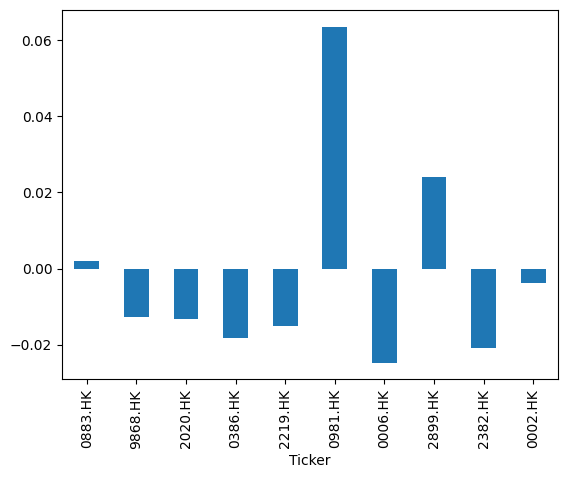

In [37]:
timie = -9
target = (pct_calculating_profit[holdings_gap.iloc[timie]+holdings.iloc[timie]].iloc[timie]-1)
target.plot(kind='bar')
target.name

In [16]:
import pandas as pd

# 按五分位數分組
quantiles = pd.qcut(ln_, q=5, labels=False)  # 分組標籤：0, 1, 2, 3, 4

# 查看每組的樣本數量和平均值
group_stats = ln_.groupby(quantiles).agg(['count', 'mean', 'std', 'min', 'max'])
print(group_stats)

AttributeError: 'DataFrame' object has no attribute 'flatten'

In [14]:
# 將因子分組標籤對應到收益數據
ln_groups = pd.DataFrame({'ln_': ln_, 'profit': pct_calculating_profit - 1})
ln_groups['group'] = quantiles

# 按組計算平均收益
group_profit = ln_groups.groupby('group')['profit'].mean()
print(group_profit)

# 可視化因子組收益
group_profit.plot(kind='bar', title="Average Profit by Factor Quantile", xlabel="Quantile", ylabel="Average Profit")
plt.show()

ValueError: If using all scalar values, you must pass an index

In [15]:
# 剔除極端值
ln_cleaned = ln_[(ln_ > ln_.mean() - 3 * ln_.std()) & (ln_ < ln_.mean() + 3 * ln_.std())]

# 再次進行描述性統計和分組檢查
print(ln_cleaned.describe())

Ticker     0001.HK     0002.HK     0003.HK     0005.HK     0006.HK  \
count   485.000000  487.000000  489.000000  485.000000  489.000000   
mean     -0.000367    0.000003   -0.000122   -0.000010   -0.000173   
std       0.006516    0.004979    0.005233    0.008314    0.004908   
min      -0.022278   -0.014839   -0.017872   -0.028331   -0.018193   
25%      -0.004728   -0.002473   -0.001791   -0.004389   -0.002625   
50%       0.000000    0.000000    0.000000    0.000000    0.000000   
75%       0.003582    0.002486    0.001797    0.005141    0.002006   
max       0.022223    0.016612    0.017310    0.023341    0.014724   

Ticker     0011.HK     0016.HK     0027.HK     0175.HK     0291.HK  ...  \
count   489.000000  489.000000  487.000000  488.000000  488.000000  ...   
mean      0.000435    0.000202    0.000816    0.000767    0.000004  ...   
std       0.006016    0.007387    0.009235    0.010451    0.010256  ...   
min      -0.019585   -0.027637   -0.024652   -0.032311   -0.032146  .